# Minimal GAN in PyTorch

Generative adversarial network (GAN) are well-known deep generative models proposed by [Ian Goodfellow](https://www.iangoodfellow.com) that could be used for synthesising data. It consists of two components, a generator (G) network that learns the data distribution and generates new examples and a discriminator (D) network that distinguishes between real and fake examples i.e. examples generated by G. We will implement a series of tasks related to GANs using MNIST and Fashion-MNIST datasets.

Prior to running the code, it is necessary to install a package manager e.g. [conda](https://docs.conda.io/en/latest/), and [PyTorch](https://pytorch.org) framework.

## 1. Implement GAN in PyTorch


The first task is to implement the code using PyTorch framework. We shall report our training performance i.e. train loss as a figure and another figure containing a batch of generated images after training.

In [11]:
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import torch
import torchvision
import numpy
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision.utils as vutils
import os
import torch.nn.functional as F

# Set random seed for reproducibility
torch.manual_seed(42)

# Noise dimensions
zdim = 50

# BATCH Samples
Nsamples = 100

# Choose dataset
dataset_name = 'mnist'

# Create output directory
output_dir = 'res'
os.makedirs(output_dir, exist_ok=True)


In [12]:
# Load dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

if dataset_name == 'mnist':
    dataset = datasets.MNIST('data', train=True, download=True, transform=transform)
else:
    dataset = datasets.FashionMNIST('data', train=True, download=True, transform=transform)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=Nsamples, shuffle=True)

In [13]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [14]:
# Define the generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(zdim, 128)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2)
        self.fc4 = nn.Linear(self.fc3.out_features, 784)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        return torch.tanh(self.fc4(x))

# Define the discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(784, 1024)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features//2)
        self.fc4 = nn.Linear(self.fc3.out_features, 1)


    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.3)
        return torch.sigmoid(self.fc4(x))

# Create the generator and discriminator
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Loss function
criterion = nn.BCELoss()

lr = 0.0002
# Optimizers
G_optimizer = optim.Adam(generator.parameters(), lr = lr)
D_optimizer = optim.Adam(discriminator.parameters(), lr = lr)

In [15]:
# Training loop
# Training loop
epoch = int(20)

D_losses = []
G_losses = []

for i in range(epoch):
    for real_images, _ in dataloader:
        real_images = real_images.view(-1, 784).to(device)
        batch_size = real_images.size(0)

        # Train discriminator with real images
        D_optimizer.zero_grad()
        real_labels = torch.ones(batch_size, 1).to(device)
        real_outputs = discriminator(real_images)
        D_loss_real = criterion(real_outputs, real_labels)

        # Train discriminator with generated images
        z = torch.randn(batch_size, zdim).to(device)
        fake_images = generator(z)
        fake_labels = torch.zeros(batch_size, 1).to(device)
        fake_outputs = discriminator(fake_images)
        D_loss_fake = criterion(fake_outputs, fake_labels)
        D_loss = D_loss_real + D_loss_fake
        D_loss.backward()
        D_optimizer.step()

        # Train generator
        G_optimizer.zero_grad()
        z2 = torch.randn(batch_size, zdim).to(device)
        fake_images2 = generator(z2)
        fake_outputs2 = discriminator(fake_images2)
        real_labels2 = torch.ones(batch_size, 1).to(device)
        G_loss = criterion(fake_outputs2, real_labels2)
        G_loss.backward()
        G_optimizer.step()

        # Append losses to lists
        D_losses.append(D_loss.item())
        G_losses.append(G_loss.item())

        # Print and plot losses at regular intervals
    print(f'Epoch [{i+1}/{epoch}], Discriminator Loss: {D_loss.item():.4f}, Generator Loss: {G_loss.item():.4f}')


Epoch [1/20], Discriminator Loss: 0.1043, Generator Loss: 5.6333
Epoch [2/20], Discriminator Loss: 0.3470, Generator Loss: 3.1712
Epoch [3/20], Discriminator Loss: 0.4112, Generator Loss: 5.6136
Epoch [4/20], Discriminator Loss: 0.2265, Generator Loss: 5.4928
Epoch [5/20], Discriminator Loss: 0.2547, Generator Loss: 4.9872
Epoch [6/20], Discriminator Loss: 0.3031, Generator Loss: 2.9342
Epoch [7/20], Discriminator Loss: 0.5869, Generator Loss: 3.2109
Epoch [8/20], Discriminator Loss: 0.3935, Generator Loss: 3.6187
Epoch [9/20], Discriminator Loss: 0.4408, Generator Loss: 3.2134
Epoch [10/20], Discriminator Loss: 0.3714, Generator Loss: 2.7072
Epoch [11/20], Discriminator Loss: 0.4384, Generator Loss: 2.4943
Epoch [12/20], Discriminator Loss: 0.4361, Generator Loss: 3.1562
Epoch [13/20], Discriminator Loss: 0.4902, Generator Loss: 2.4550
Epoch [14/20], Discriminator Loss: 0.5044, Generator Loss: 2.6139
Epoch [15/20], Discriminator Loss: 0.4462, Generator Loss: 3.1491
Epoch [16/20], Disc

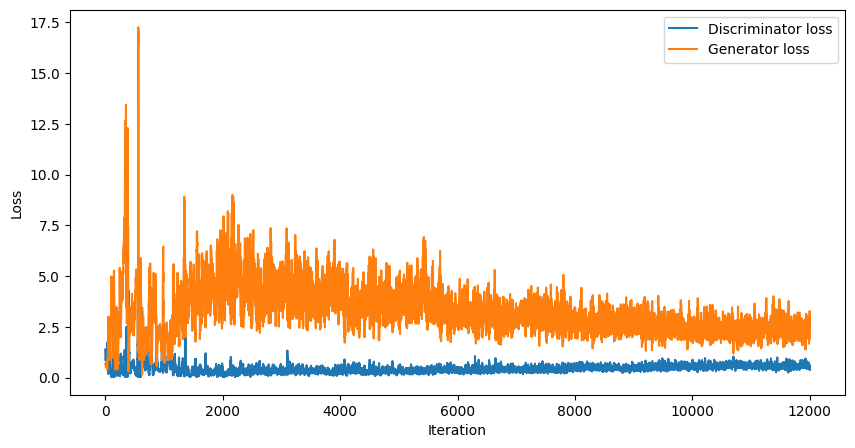

In [18]:
def plot_losses(D_losses, G_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(D_losses, label='Discriminator loss')
    plt.plot(G_losses, label='Generator loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_losses(D_losses, G_losses)


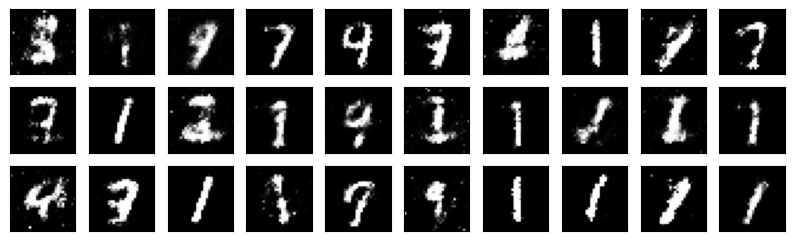

In [19]:

z = torch.randn(30, zdim).to(device)
generated_images = generator(z).detach().cpu()

fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(10, 10)
for j, sample in enumerate(generated_images):
  ax = plt.subplot(gs[j])
  ax.set_xticks([])
  ax.set_yticks([])
  plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

# visualize_generated_images(generator)